
#<center>**Analisis de trazas**</center>
<center><small><b>Presentado por:<br> María Camila Fernández Isaza, Miguel Ángel Rippe Pereria, Erika Daniela Romero Ramirez y Santiago Pérez González </small></b></center> 

---
<center>En este archivo se presenta la realización del análisis de trazas de archivos presentados en clase para así determinar si las mismas presentan persistencia o no a partir del cálculo del parámetro de Hurst<br> <b> Profesor: Joaquín Sánchez </b><br> Universidad Sergio Arboleda</center>
 






## Bibliotecas utilizadas

In [1]:
#@title
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math
import scipy.stats as sps
import seaborn as sb

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Metadatos:
* **Interval**: refiere al intervalo de tiempo de la traza (en segundos)
* **Transfer**: refiere a los datos transferidos (en bytes)
* **Bandwith**: refiere al ancho de banda utilizado (en bits por segundo)
* **Retr**: Paquetes TCP retransmitidos
* **Cwnd**: Estado variable que limita la cantidad de datos (es la ventana de congestión en bits)

\\
Retr y Cwnd: Las dos últimas columnas dependen de la traza (si se hicieron las medidas con protocolo TCP y UDP. Si es con TCP, ambas columnas aparecen)

# 1. Carga de datos

Para esto, primero se utiliza un script que crea un formato .csv de los archivos originales que Iperf3 genera. El script establece todos los datos en unidades de bits y bits por segundo (bps). Estos están en un [repositorio de GitHub](https://github.com/miguel26697/SistemasComplejos)  junto con sus resultados. A continuación se descargan para procesarse

In [2]:
files=["Bw_traza3f_2.csv","Bw_traza3f_3.csv","TrIperf5003.csv","TrIperf5004.csv"]
data_urls=["https://raw.githubusercontent.com/Pasta43/SistemasComplejos/main/formatter/"+file for file in files]
dfs = [pd.read_csv(url_file) for url_file in data_urls] 

# 2. Cálculo de media y varianza

Para realizar el análisis $R/S$ se considerará la columna *Transfer* de los datos

In [3]:
for df,filename in zip(dfs,files):
  average=df["Transfer"].mean()
  stddev= df["Transfer"].std()
  print("Para la traza",filename,"la media es",average,"con una varianza de",stddev**2,"en bits")

Para la traza Bw_traza3f_2.csv la media es 921605.000665927 con una varianza de 1355153863152.0234 en bits
Para la traza Bw_traza3f_3.csv la media es 1285145.3843015516 con una varianza de 1789305020194.612 en bits
Para la traza TrIperf5003.csv la media es 1330729.7792000002 con una varianza de 4522977631474.285 en bits
Para la traza TrIperf5004.csv la media es 6553430.58944 con una varianza de 25546950915416.9 en bits


# 3. Grafica preliminar.

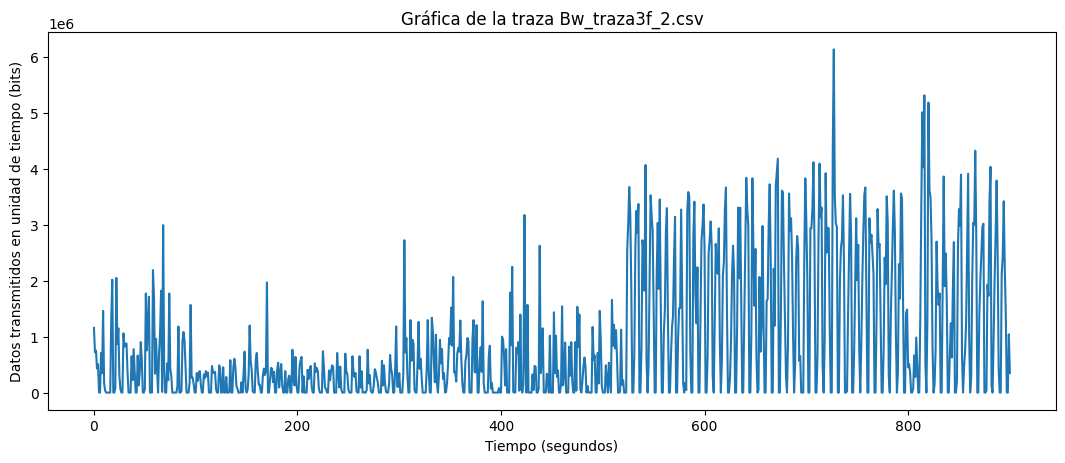

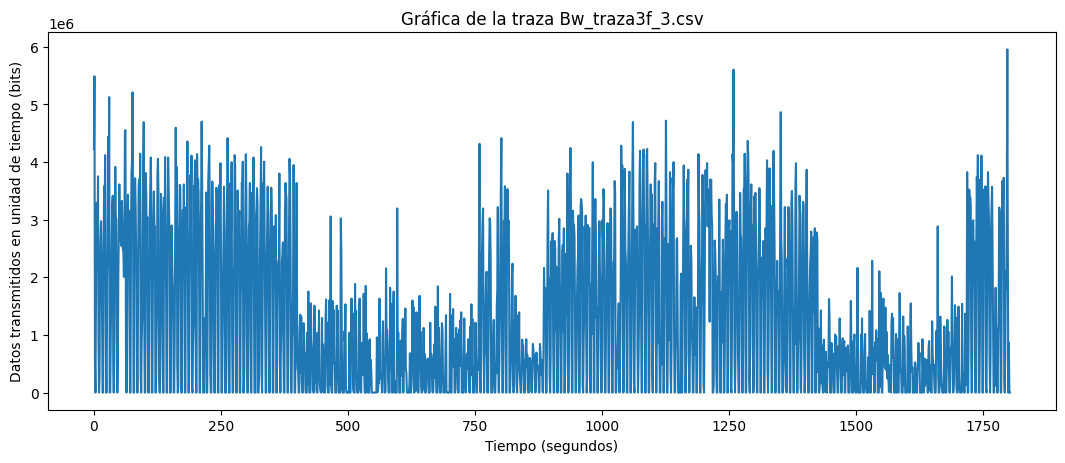

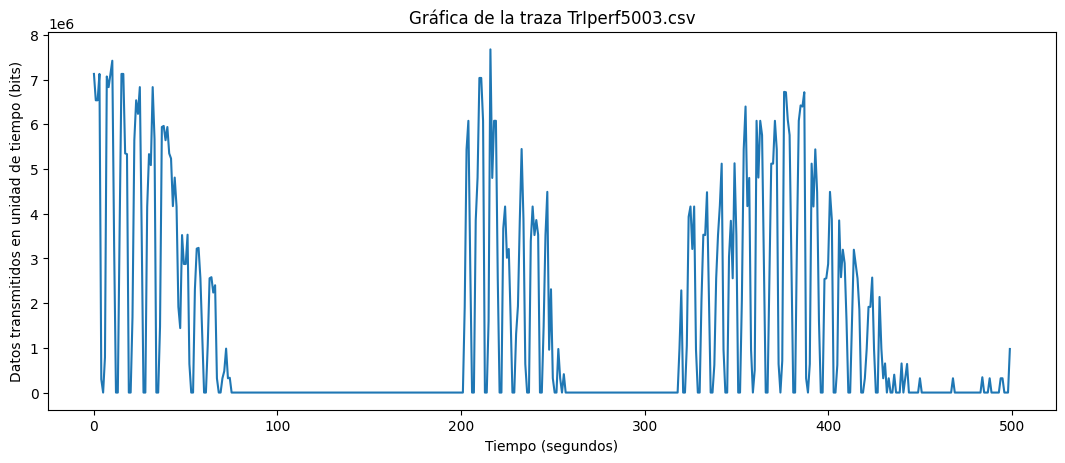

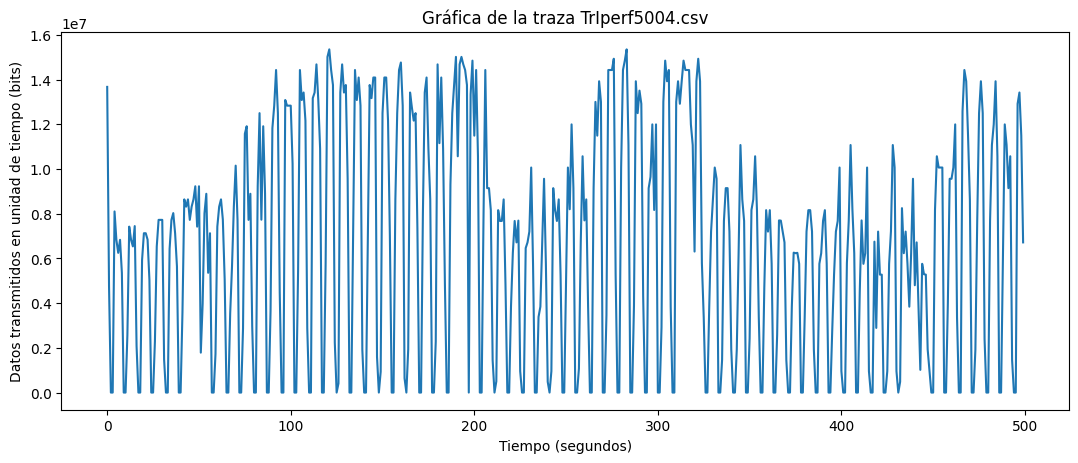

In [4]:
plt.rcParams['figure.figsize'] = [13, 5]
plt.rcParams['figure.dpi'] = 100
for df,filename in zip(dfs,files):
  x=[i for i in range(df['Transfer'].count())]
  y=df['Transfer']
  plt.plot(x,y)
  plt.xlabel("Tiempo (segundos)")
  plt.ylabel("Datos transmitidos en unidad de tiempo (bits)")
  plt.title("Gráfica de la traza "+filename)
  plt.show()

# 4. Buscar una distribución de probabilidad que se acomode al fenómeno. 

Como en clase se pedía, primero se realiza el gráfico de un histograma para cada conjunto de datos. Estos primero se dividen en intervalos de número de bits enviados utilizando la regla de Sturges para encontrar esa división:

\begin{equation}
  k=1+\log_2{N}
\end{equation}

Donde $N$ es la cantidad de muestras y $k$ el número de intervalos. El número se redondea al entero superior más cercano.

||||||||||||||||||||||||||||||||||||||||||||||||
||||||||||||||||||||||||||||||||||||||||||||||||
Distribuciones para el archivo Bw_traza3f_2.csv
Tenga en cuenta que para el eje X, las probabilidades están para el número del intervalo


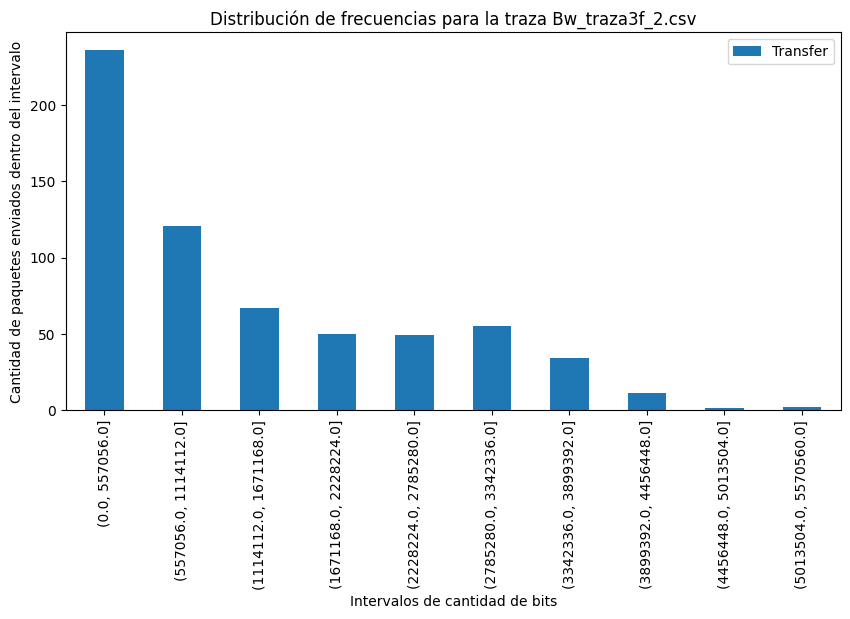

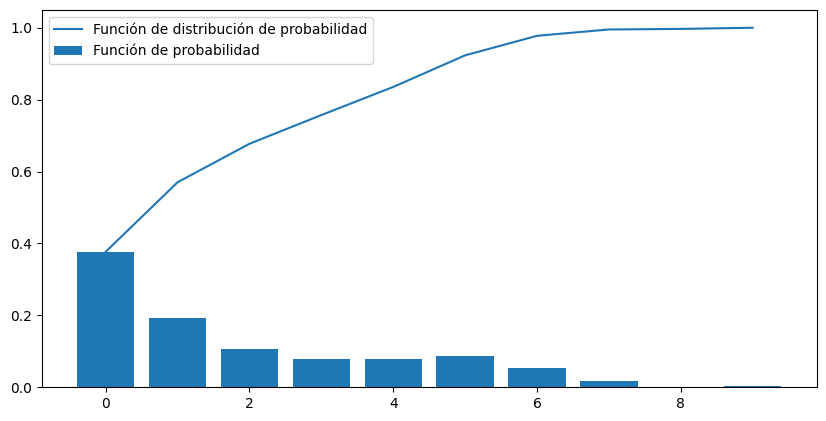

||||||||||||||||||||||||||||||||||||||||||||||||
||||||||||||||||||||||||||||||||||||||||||||||||
Distribuciones para el archivo Bw_traza3f_3.csv
Tenga en cuenta que para el eje X, las probabilidades están para el número del intervalo


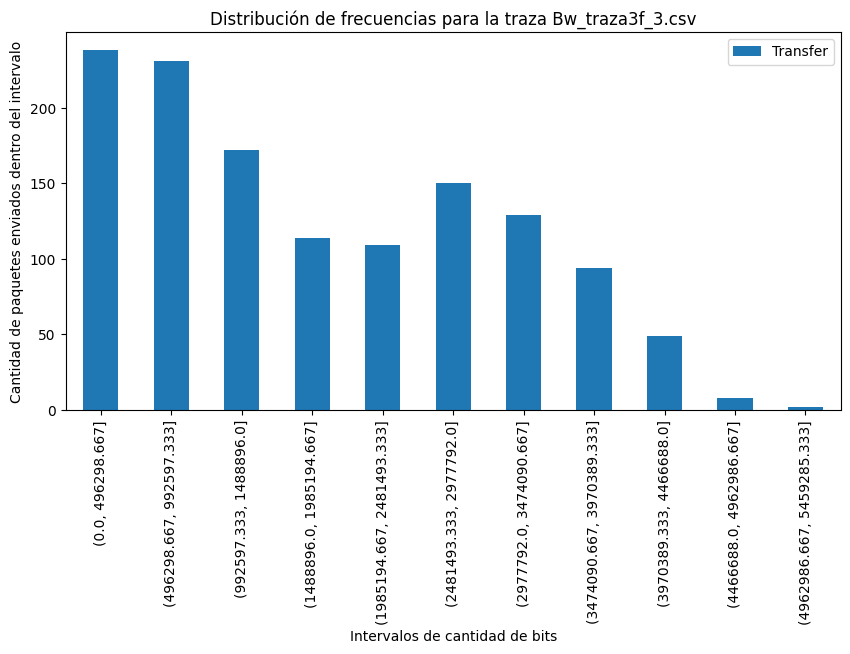

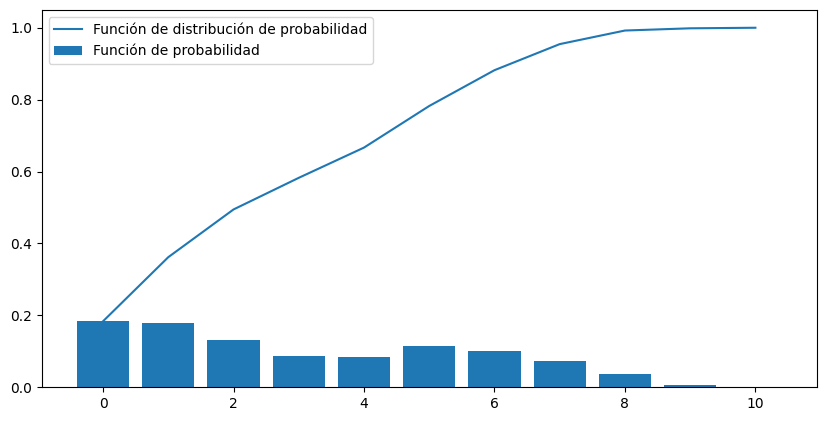

||||||||||||||||||||||||||||||||||||||||||||||||
||||||||||||||||||||||||||||||||||||||||||||||||
Distribuciones para el archivo TrIperf5003.csv
Tenga en cuenta que para el eje X, las probabilidades están para el número del intervalo


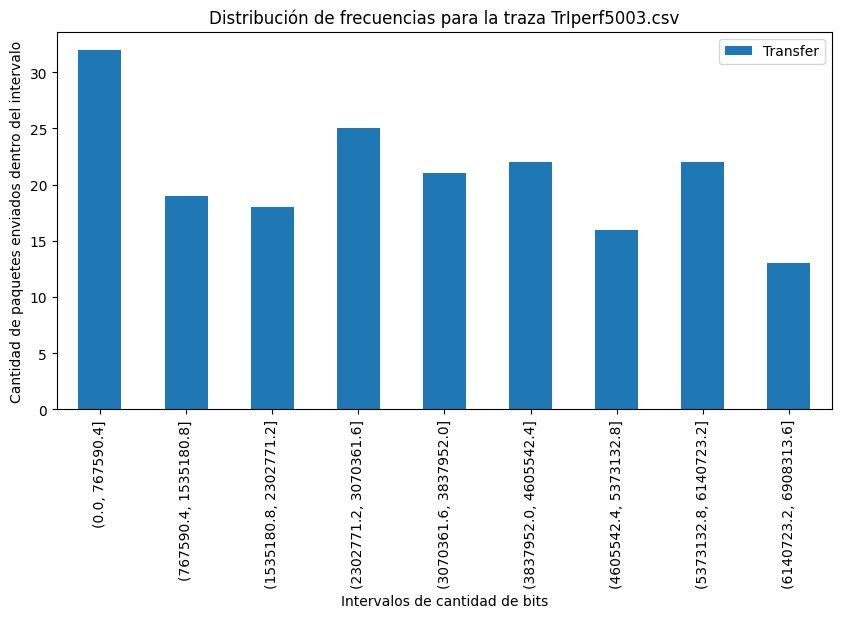

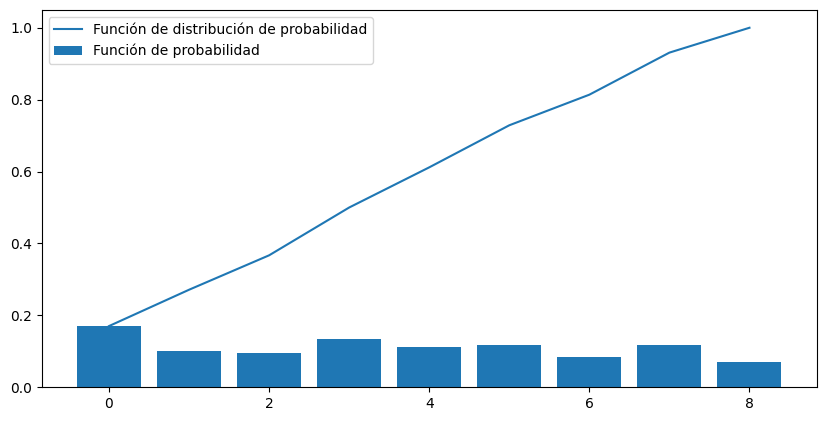

||||||||||||||||||||||||||||||||||||||||||||||||
||||||||||||||||||||||||||||||||||||||||||||||||
Distribuciones para el archivo TrIperf5004.csv
Tenga en cuenta que para el eje X, las probabilidades están para el número del intervalo


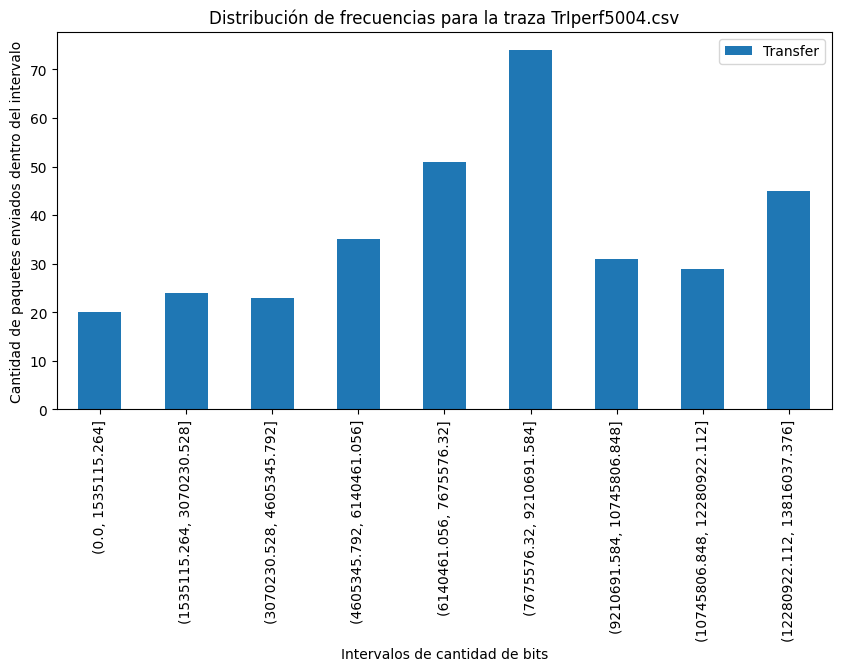

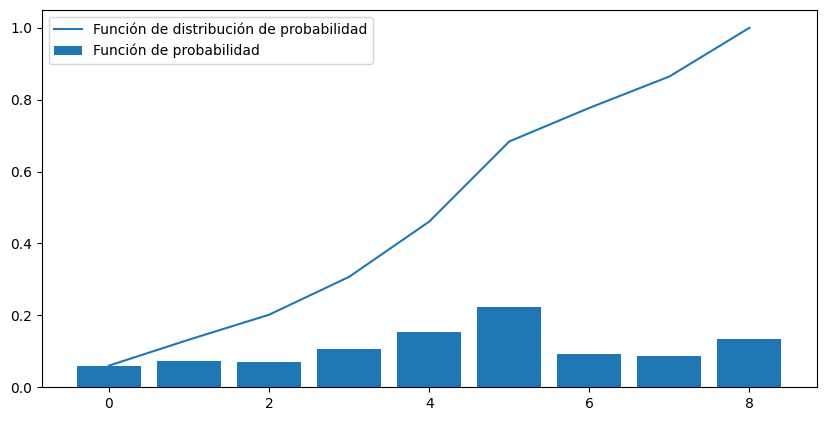

In [5]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100
for df,filename in zip(dfs,files):
  print("||||||||||||||||||||||||||||||||||||||||||||||||")
  print("===============================================")
  print("||||||||||||||||||||||||||||||||||||||||||||||||")
  print("Distribuciones para el archivo",filename)
  print("Tenga en cuenta que para el eje X, las probabilidades están para el número del intervalo")
  N=math.ceil(1+math.log2(df["Interval"].count()))
  maximum,minimum= np.max(df["Transfer"]),np.min(df["Transfer"])
  interval_size=(maximum-minimum)/N
  intervals=np.arange(start=minimum,stop=maximum,step=interval_size)
  df_temporal=df[['Transfer']]
  df_intervals=df_temporal.groupby(pd.cut(df_temporal["Transfer"],intervals)).count()
  df_intervals.plot(xlabel="Intervalos de cantidad de bits",ylabel="Cantidad de paquetes enviados dentro del intervalo",title="Distribución de frecuencias para la traza "+filename,kind='bar')
  distribution = list(df_intervals["Transfer"].to_numpy())
  probs = np.array([dist/sum(distribution) for dist in distribution])
  functionDist = np.cumsum(probs)
  plt.figure()
  xaxis = [i for i in range(len(functionDist))]
  plt.bar(xaxis,probs)
  plt.plot(xaxis,functionDist)
  plt.legend(["Función de distribución de probabilidad","Función de probabilidad"])
  plt.show()
  

# 5. Busque o calcule el parametro H

Aclaraciones:

- Para considerar la forma en que se generan los subintervalos, se tiene en cuenta la longitud de la traza y se van dividiendo los resultados entre $2p$, donde $p$ es el número de subintervalo.
- Se ignoran los valores en los que hay inderterminaciones entre el rango y la desviación estándar.
- Para estimar la certeza de los datos, se puede observar  que $R^2$ es cercano a 1 y el $p_{value} < 0.05$

||||||||||||||||||||||||||||||||||||||||||||||||
||||||||||||||||||||||||||||||||||||||||||||||||
Análisis R/S para el archivo Bw_traza3f_2.csv


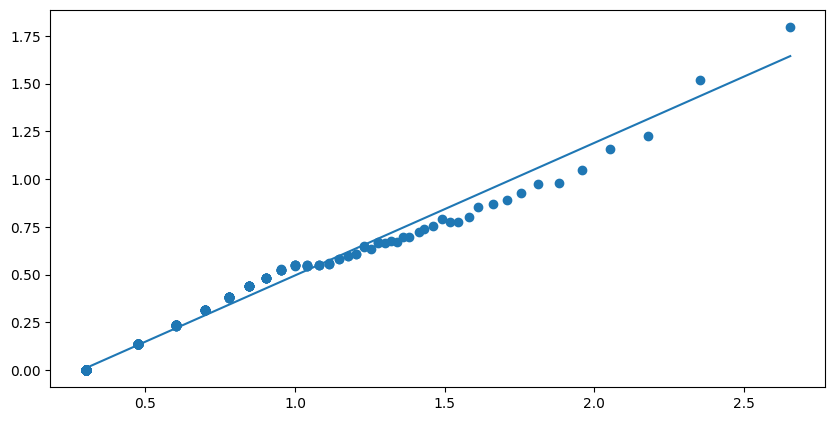

T estadístico calculado 55.04292462970827
P valor calculado 0.0
Resumen de statsmodel
Parámetro de hurst:  0.694504279224071
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                 3.863e+04
Date:                Mon, 04 Apr 2022   Prob (F-statistic):               0.00
Time:                        22:04:18   Log-Likelihood:                 981.84
No. Observations:                 450   AIC:                            -1960.
Df Residuals:                     448   BIC:                            -1951.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------

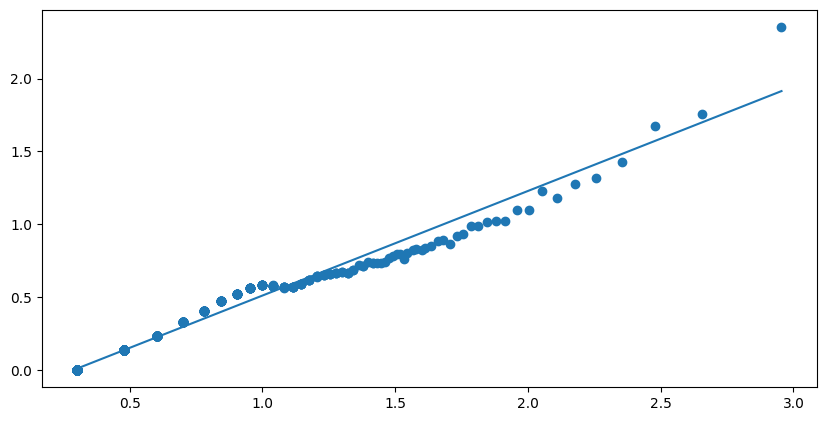

T estadístico calculado 66.36887244181298
P valor calculado 0.0
Resumen de statsmodel
Parámetro de hurst:  0.7174231479818095
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                 4.796e+04
Date:                Mon, 04 Apr 2022   Prob (F-statistic):               0.00
Time:                        22:06:57   Log-Likelihood:                 1708.4
No. Observations:                 901   AIC:                            -3413.
Df Residuals:                     899   BIC:                            -3403.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----

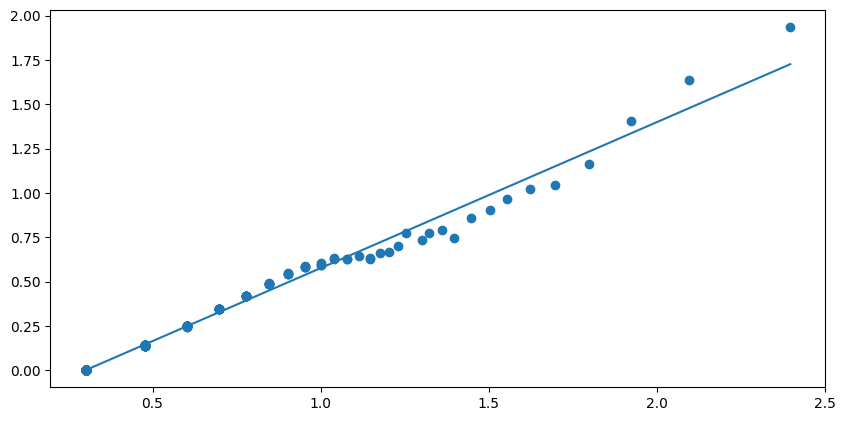

T estadístico calculado 61.235128042500506
P valor calculado 0.0
Resumen de statsmodel
Parámetro de hurst:  0.8233080275953174
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 2.432e+04
Date:                Mon, 04 Apr 2022   Prob (F-statistic):          1.01e-248
Time:                        22:07:09   Log-Likelihood:                 522.56
No. Observations:                 249   AIC:                            -1041.
Df Residuals:                     247   BIC:                            -1034.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----

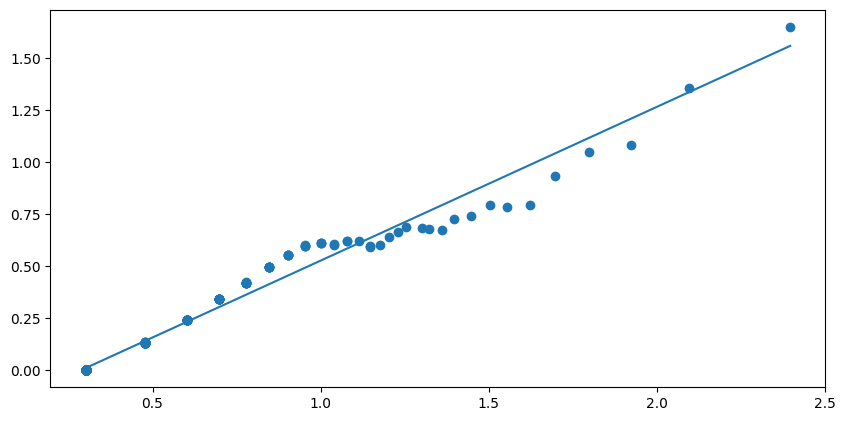

T estadístico calculado 34.051208173352265
P valor calculado 0.0
Resumen de statsmodel
Parámetro de hurst:  0.7395494909402224
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                 1.105e+04
Date:                Mon, 04 Apr 2022   Prob (F-statistic):          4.59e-207
Time:                        22:07:22   Log-Likelihood:                 451.10
No. Observations:                 249   AIC:                            -898.2
Df Residuals:                     247   BIC:                            -891.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----

In [6]:
prediction = lambda x,slope, constant: x*slope+constant
for df,filename in zip(dfs,files):
  print("||||||||||||||||||||||||||||||||||||||||||||||||")
  print("===============================================")
  print("||||||||||||||||||||||||||||||||||||||||||||||||")
  print("Análisis R/S para el archivo",filename)
  df[df['Transfer']==0]=1
  n = df["Transfer"].count()
  N=np.nan_to_num(df["Transfer"].to_numpy())

  tau=np.array([])
  X = np.arange(1,n)
  Y = np.array([])
  for p in X:
      m = math.ceil(n/(2*p))
      rs_array = np.array([])
      for i in np.arange(0,p):
          subsample = np.nan_to_num(np.array(N[i*m:(i+1)*m]))
          mean = np.average(subsample)
          deviate = np.cumsum(subsample-mean)
          difference = max(deviate) - min(deviate)
          stdev = np.std(subsample)
          if(stdev!=0):  
            rescaled_range = difference/stdev
            rs_array = np.append(rs_array, rescaled_range)
      if(len(rs_array)!=0):
        Y = np.append(Y, np.log10(np.average(rs_array)))
        tau=np.append(tau,m)
  reg = sm.OLS(Y, sm.add_constant(np.log10(tau)))
  res = reg.fit()
  hurst = res.params[1]
  tstat = (res.params[1]-0.5)/res.bse[1]
  pvalue = 2*(1 - sps.t.cdf(abs(tstat),res.df_resid))
  nplogvalues=np.log10(tau)
  predict = [prediction(value,res.params[1],res.params[0]) for value in nplogvalues]
  plt.plot(nplogvalues,predict)
  plt.scatter(nplogvalues,Y)  
  plt.show()
  print("T estadístico calculado",tstat)
  print("P valor calculado",pvalue)
  print("Resumen de statsmodel")
  print("Parámetro de hurst: ",hurst)
  print(res.summary())
print("||||||||||||||||||||||||||||||||||||||||||||||||")
print("===============================================")
print("||||||||||||||||||||||||||||||||||||||||||||||||")

#6. Realice una conclusión que describa el fenómeno

A partir de los resultados obtenidos en cada una de las trazas, se puede concluir que cada uno de ellos presenta persistencia ya que en cada uno de ellos se obtuvo un $H>0.5$. Si los datos presentados se realizaron en una red de 3 o más nodos, puede concluirse que dicha red es un sistema complejo 